In [101]:
#https://plotly.com/python/reference/

%matplotlib inline
%config InlineBackend.print_figure_kwargs={'facecolor' : '#0d1238'}

import io
import json
import os
import pandas as pd
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from datetime import datetime, timedelta
from IPython.display import Markdown, display, Image, clear_output, Video
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from PIL import Image as PILImage

# LOCAL GIT REPOSITORY LOCATION FOR https://github.com/CSSEGISandData/COVID-19
directory = '/Users/davidmorton/Documents/COVID-19/csse_covid_19_data/csse_covid_19_daily_reports/'

!git -C $directory pull

state_names = pd.read_csv('states.csv').set_index('State').to_dict()['Abbreviation']
bgcolor = '#0d1238'

remote: Enumerating objects: 114, done.
remote: Counting objects: 100% (114/114), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 156 (delta 107), reused 113 (delta 106), pack-reused 42
Receiving objects: 100% (156/156), 978.62 KiB | 2.56 MiB/s, done.
Resolving deltas: 100% (109/109), completed with 19 local objects.
From https://github.com/CSSEGISandData/COVID-19
   246d61d2..6b22e31d  master     -> origin/master
   f528fa66..15806310  web-data   -> origin/web-data
Updating 246d61d2..6b22e31d
Fast-forward
 .../csse_covid_19_daily_reports/07-08-2020.csv     | 3807 ++++++++++++
 .../csse_covid_19_daily_reports_us/07-08-2020.csv  |   59 +
 .../csse_covid_19_time_series/Errata.csv           |    2 +
 .../time_series_covid19_confirmed_US.csv           | 6524 ++++++++++----------
 .../time_series_covid19_confirmed_global.csv       |  534 +-
 .../time_series_covid19_deaths_US.csv              | 6524 ++++++++++----------
 .../time_series_covid19_deaths_global.csv          |

In [107]:
def get_census_info():
    return (
        pd.read_csv("co-est2019-alldata.csv", encoding = "ISO-8859-1") # Fetch the file
        .query('SUMLEV == 50')                                         # 40 is states, 50 is counties
        [['STATE', 'COUNTY', 'CTYNAME', 'POPESTIMATE2019']]            # Keep Just population estimate
        .assign(fips=lambda x: (x['STATE'] * 1000) + x['COUNTY'])      # FIPS = stateId*1000+countyId                                # 
        .rename(columns={'POPESTIMATE2019':'pop'})                     # Shorten Population Estimate column
        [['fips', 'pop']]                                              # Keep just FIPS and PopEstimate
        .set_index('fips')                                             # Index by FIPS
    )

def get_daily_report_data():
    states = list(state_names.keys())                                 # List of 51 states (including DC)
    return (
        pd.concat([ \
            pd.read_csv(directory+file) \
            .assign(date=datetime.strptime(file, '%m-%d-%Y.csv')) \
            for file \
            in os.listdir(directory) \
            if file.endswith(".csv") \
        ])                                                            # List the files, appending a date column to each file's data
        .reset_index()                                                # Reset the index
        .query('FIPS.notna()')                                        # Pick only items with FIPS values
        .assign(FIPS=lambda x:x['FIPS'].astype(int))                  # And cast that FIPS value to integer
        .query('Province_State.isin(@states)')                        # Only the states
    )

def get_county_percentages():
    daily_report_data = get_daily_report_data()
    
    starter = (
        daily_report_data
        [['Confirmed', 'FIPS', 'date']]                           # Keep these three columns
        .rename(columns={'Confirmed':'confirmed', 'FIPS':'fips'}) # Rename for simplicity
        .drop_duplicates(['date','fips'])                         # There are a few duplicates. Drop them. 
        .pivot(values='confirmed', index='date', columns='fips')  # Create the pivot table. 
        .fillna(0)                                                # Fill NA values here.
    )
    
    # Here we're going to ensure cumulative confirmed values are always increasing. 
    # We'll do this by comparing the existing values against the cumulative maximum 
    # for that time series, removing the numbers that don't conform to this, and then 
    # interpolating those missing values. For an example of a time series that does 
    # this, look at the Brazoria County values (48049), between June 8 and 9. The 
    # cumulative maximum drops from 990 to 770, which, since we're creating a differential
    # here, would inject a massive negative value into our rolling average. This clearly
    # isn't the way it's supposed to be, because when you look at the data between
    # June 15 and June 16, the values jump again from 864 to 1495. We'll smooth those
    # values out here, in the absence of any accessible SME who can tell us what 
    # happened, and in the interest of time. 
    daily_report_data = (
        starter[starter >= starter.cummax()] # Remove values that are lower than the time series cumulative maximum
        .interpolate()                       # Interpolate the "actual" values for those items.
        .diff()                              # _Now_ we get our dialy differential. 
        .rolling(window=7)                   # Roll this value 7 days for smoothness. 
        .mean()                              # Take the mean of the rolling window. 
        .dropna()                            # Drop the first 6 rows, an artifact of rolling.
        .T                                   # Transpose the whole DataFrame
    )

    # Grab the county populations
    county_populations = get_census_info()
    
    # Divide the values of new confirmed cases by the county population,
    # and then multiply by 100,000 to get the "per 100,000" people metric.
    return (daily_report_data.div(county_populations.iloc[:,0], axis=0).dropna()) * 100000

def get_allcounties():
    # Get the GEOJson file for the counties.
    with open(os.getcwd() + '/geojson-counties-fips.json') as response:
        allcounties = json.load(response)
    return allcounties

def draw_choropleth(row, county_geojson, colorscale, zmax, store_intermediate_files, timeinterpolation, legend=None, new_cases_info=None):

    if (new_cases_info is None):
        new_cases_info = get_new_cases_info()
        
    clear_output(wait=True)
    date = row.name
    print(date)
    
    foldername = 'gitignore-county-spread-images'
    filename = '{0}/{1:%Y-%m-%d-%H-%M}.png'.format(foldername, date)
    if store_intermediate_files == True:
        if (not os.path.exists(foldername)):
            os.mkdir(foldername)
        if (os.path.exists(filename)):
            return PILImage.open(filename)
    
    if (legend is None):
        legend=get_legend()
        
    calendar = get_calendar(date.year, date.month, date.day)
    new_case_graph = create_new_case_graph(date.year, date.month, date.day, date.hour, timeinterpolation, new_cases_info)
        
    local_directory = os.getcwd()

    row = row[row.index.isin([stateid['id'] for stateid in county_geojson['features']])]

    row = row.reset_index().rename(columns={date:'confirmed'})

    for feature in county_geojson["features"]:
        feature["properties"]["FIPS"] = str(int(feature["properties"]["STATE"])) + feature["properties"]["COUNTY"]

    bgcolor = '#0d1238'
    fig = px.choropleth(row, 
                        geojson=county_geojson, 
                        locations='fips', 
                        color='confirmed',
                        color_continuous_scale=colorscale,
                        featureidkey='properties.FIPS',
                        projection='albers usa',
                        title="Where is COVID Spreading?",
                        template='plotly_dark',
                        range_color=[0,zmax],
                        labels={"confirmed": ""}, 
                        width=1920/2,
                        height=1080/2
                      )

    fig.update_geos(
        showcountries=False,
        showcoastlines=True, 
        showframe=False,
        oceancolor=bgcolor,
        lakecolor=bgcolor,
        showland=False, 
        bgcolor=bgcolor)
   
    fig.update_layout(
        plot_bgcolor=bgcolor, 
        paper_bgcolor=bgcolor, 
        title_text = 'COVID-19 Rate of Spread',
        title_xanchor = 'center',
        font=dict(size=18),
        title_x = 0.5,
        title_y = 0.94,
        margin=(dict(
            t=75,
            b=100,
            r=0,
            l=0
        )),
        coloraxis=dict(
            showscale=False,
            colorbar=dict( 
                ticktext=["0","10","20","30", "40","50+"], 
                tickvals=[0,10,20,30,40,50]
            )
        ),
        annotations=[
            dict(
                x=0.02,
                y=-0.23,
                font=dict(
                    color="#A1A1A1",
                    size=10
                ),
                showarrow=False,
                text='Data from Johns Hopkins University COVID-19 DataSet',
                xref="paper",
                yref="paper"
            ),
            dict(
                x=0.5,
                y=1.05,
                yanchor='top',
                xanchor='center',
                font=dict(
                    size=12
                ),
                showarrow=False,
                text='Weekly Rolling Average of New Cases Per 100,000 People',
                xref="paper",
                yref="paper"
            )
        ]
    )
    
    fig.update_traces(marker_line_width=0, showscale=False)
    img_bytes = fig.to_image(format="png")
    image = PILImage.open(io.BytesIO(img_bytes))
    
    image.paste(legend, (300,460), legend)
    image.paste(calendar, (750,350), calendar)
    image.paste(new_case_graph, (30,375), new_case_graph)
    
    if store_intermediate_files == True:
        image.save(filename)
    return image

def draw_choropleth_image(row, county_geojson, colorscale, zmax):
    image = draw_choropleth(row, county_geojson, colorscale, zmax)
    url = 'covid19-county-cases.gif'
    image.save(url)
    return url + "?c=" + str(random.randint(0,2e9))

def get_new_cases_info(daily_report_data=None):
    if (daily_report_data is None):
        daily_report_data=get_daily_report_data()
        
    starter = (
        daily_report_data
        [['Confirmed', 'FIPS', 'date']]                           # Keep these three columns
        .rename(columns={'Confirmed':'confirmed', 'FIPS':'fips'}) # Rename for simplicity
        .drop_duplicates(['date','fips'])                         # There are a few duplicates. Drop them. 
        .pivot(values='confirmed', index='date', columns='fips')  # Create the pivot table. 
        .fillna(0)                                                # Fill NA values here.
    )

    rep_a = (
        starter[starter >= starter.cummax()] # Remove values that are lower than the time series cumulative maximum
        .interpolate()                       # Interpolate the "actual" values for those items.
        .rolling(window=7)                   # Roll this value 7 days for smoothness. 
        .mean()                              # Take the mean of the rolling window. 
        .dropna()                            # Drop the first 6 rows, an artifact of rolling.
        .T                                   # Transpose the whole DataFrame
    )

    return (rep_a.sum().diff().dropna())

def create_new_case_graph(year, month, day, hour, timeinterpolation, new_cases_info=None):
    
    if (new_cases_info is None):
        new_cases_info = get_new_cases_info()
    
    new_cases_info = new_cases_info.resample(rule=timeinterpolation).asfreq().interpolate()
    d = datetime(year,month,day, hour)
    datamax = new_cases_info.max()
    data = new_cases_info.where(lambda x:x.index <= d)

    imgheight = 200
    d3 = pd.DataFrame([a for a in np.linspace(0, 255, 200)**2])

    y = pd.Series(data.values[:-1]).fillna(0)
    y = (y.div(datamax) * imgheight)
    d2 = [np.repeat(0, imgheight - i).tolist() + np.repeat(1, i).tolist() for i in y]
    d2 = pd.DataFrame(d2).T
    d2 = d2[d2==1]
    d2[-1:] = 1
    d4 = d2.mul(d3[0], axis='index')

    x = np.array(list(range(0, len(y))))

    z = np.array(y)
    z_min, z_max = -np.abs(z).max(), np.abs(z).max() 

    current_cmap = plt.cm.get_cmap('inferno_r')
    current_cmap.set_bad(color=bgcolor)

    fig,ax = plt.subplots()
    plt.imshow(d4, cmap=current_cmap, vmin=0, extent=[0,50,0,100], aspect=0.3, interpolation='gaussian')
    ax.xaxis.label.set_text('{0:,.0f} New Cases'.format(data.dropna()[-1]))
    ax.xaxis.label.set_color('white')
    ax.xaxis.label.set_fontsize(40)
    ax.yaxis.set_visible(False)
    ax.spines['top'].set_color(bgcolor)
    ax.spines['bottom'].set_color(bgcolor)
    ax.spines['left'].set_color(bgcolor)
    ax.spines['right'].set_color(bgcolor)
    ax.xaxis.set_ticks([])
    for t in ax.xaxis.get_ticklines(): t.set_color(bgcolor)

    iobytes = io.BytesIO()
    plt.savefig(iobytes, bbox_inches='tight', facecolor=bgcolor, pad_inches=0.02, dpi=30)


    iobytes.seek(0)
    image = PILImage.open(iobytes)
    plt.close()
    return image

def get_legend():
    fig,ax = plt.subplots(figsize=(6,0.3))
    sns.heatmap(pd.DataFrame([[i, 1] for i in range(0, 50)]).T, ax=ax, cbar=False, cmap="inferno");

    ax.tick_params(axis='both', which='both', length=0)
    ax.set_yticklabels([], color='white')
    ax.set_xticks([0, 10, 20, 30, 40, 49])
    ax.set_xticklabels([0, 10, 20, 30, 40, "50+"], color='white', size=12)
    ax.set(
        xlabel='',
        ylabel=''
    )
    plt.xticks(rotation=0)
    plt.tick_params(labeltop=True, labelbottom=False)
    iobytes = io.BytesIO()
    #plt.tight_layout()
    plt.savefig(iobytes, bbox_inches='tight', facecolor=bgcolor, pad_inches=0.02, dpi=75)
    iobytes.seek(0)
    image = PILImage.open(iobytes)
    plt.close()
    return image

def draw_single_choropleth(year, month, day):
    county_geojson=get_allcounties()
    originalData = get_county_percentages().T.clip(0, 50)
    zmax = originalData.max().max()
    binned = list(range(0,9))
    bins = pd.qcut(binned, q=8, retbins=True)[1]
    colorstops = (bins - bins.min()) / (bins.max() - bins.min())
    colorscale = list(zip(colorstops, getattr(px.colors.sequential, 'Inferno')))
    row = originalData.loc[datetime(year,month,day)]
    return draw_choropleth(row, county_geojson, colorscale, zmax, False, timeinterpolation='1D')
    
def make_animation(totalduration, timeinterpolation, theme, filename, store_intermediate_files):
    
    county_geojson=get_allcounties()
    originalData = get_county_percentages().T.clip(0, 50)
    data = originalData.resample(rule=timeinterpolation).asfreq().interpolate()
    daily_report_data = get_daily_report_data();
    new_cases_info = get_new_cases_info()
    
    perslide = (totalduration*1000)/(len(data) - 1);
    
    print('Frames will be shown for {0} milliseconds'.format(perslide))
    
    rows = [data.iloc[i] for i in range(0, len(data))]

    binned = list(range(0,9))
    bins = pd.qcut(binned, q=8, retbins=True)[1]
    
    colorstops = (bins - bins.min()) / (bins.max() - bins.min())
    colorscale = list(zip(colorstops, getattr(px.colors.sequential, theme)))
    
    zmax = originalData.max().max()
    legend = get_legend();

    
    images = [draw_choropleth(row, county_geojson, colorscale, zmax, store_intermediate_files, timeinterpolation, legend, new_cases_info) for row in rows]
    #images.extend([images[-1] for i in range(0, repeatlast)])
    
    url = filename + '.gif'
    images[0].save(url,
                   save_all=True, append_images=images[1:], optimize=True, duration=perslide, loop=0, dpi=100)
    clear_output()
    fadeout_time = totalduration - 2 + 117.59;
    #!ffmpeg -i cold-day.mp3 -ss 00:01:57.590 -t {totalduration} -filter_complex afade=t=out:st={fadeout_time}:d=2 -y spread-music.mp3
    #!ffmpeg -i {url} -i spread-music.mp3 -y -movflags faststart -pix_fmt yuv420p -vf "scale=trunc(iw/2)*2:trunc(ih/2)*2" -vsync 0 {filename}.mp4
    !ffmpeg -i {url} -y -movflags faststart -pix_fmt yuv420p -vf "scale=trunc(iw/2)*2:trunc(ih/2)*2" -vsync 0 {filename}.mp4 > /dev/null 2>&1
    return '{0}/{1}.mp4'.format(os.getcwd(), filename)

def get_calendar(year, month, date):
    daysinmonth = (datetime(year, month%12+1,1) - timedelta(days=1)).date().day
    weekdaytostart = datetime(year, month, 1).weekday()
    weekdayfordate = datetime(year, month, date).weekday()
    start_on_sunday = True
    sunday_adjustment = 1 if start_on_sunday else 0
    days_of_week = [[a[0], a[1]] for a in zip(range(1, daysinmonth+1), [(i+sunday_adjustment+weekdaytostart)%7 for i in range(0, daysinmonth)])]
    monthly_calendar_dates = [[None,i] for i in range(0, days_of_week[0][1])] + days_of_week + [[None,i] for i in range(days_of_week[-1][1]+1, 7)]

    calendar_data = pd.DataFrame([[j[0] for j in monthly_calendar_dates[i*7:(i*7)+7]] for i in list(range(0, int(len(monthly_calendar_dates)/7)))])
    week_number = calendar_data[calendar_data == date].idxmax(axis=1).idxmax()
    day_number = calendar_data[calendar_data == date].idxmax(axis=0).idxmax()
    calendar_data_display = pd.DataFrame(calendar_data / calendar_data / 2).fillna(0)

    calendar_data_display.iloc[week_number,day_number] = 1
    title = '{0:%B %Y}'.format(datetime(year,month,date))

    fig, ax = plt.subplots(1, figsize=(2,1.5), dpi=150)

    h = bgcolor.lstrip('#')
    start_color = [tuple(int(h[i:i+2], 16)/255 for i in (0, 2, 4))][0]+(1,)
    end_color = (1, 1, 1, 1)
    spectrum = [a for a in np.linspace(start_color, end_color, 8)]
    cmap = LinearSegmentedColormap.from_list('Custom', spectrum, len(spectrum))

    annotations = calendar_data.fillna(0).applymap(lambda x:str(int(x))).replace('0', '')
    ax = sns.heatmap(calendar_data_display, linewidths=2, linecolor=bgcolor, cmap=cmap, cbar=False, facecolor=None, ax=ax,
               yticklabels=[], xticklabels=[], annot=annotations, fmt='', annot_kws={"size": 8});

    ax.tick_params(axis='both', which='both', length=0)

    ax.set(
        xlabel='',
        ylabel=''
    )

    ax.set_title(title, color='white')
    iobytes = io.BytesIO()
    plt.savefig(iobytes, bbox_inches='tight', facecolor=bgcolor, pad_inches=0.02, dpi=100)
    iobytes.seek(0)
    image = PILImage.open(iobytes)
    plt.close()
    return image

def get_legend():
    fig,ax = plt.subplots(figsize=(6,0.15))
    sns.heatmap(pd.DataFrame([[i] for i in range(0, 50)]).T, ax=ax, cbar=False, cmap="inferno");

    ax.tick_params(axis='both', which='both', length=0)
    ax.set_yticklabels([], color='white')
    ax.set_xticks([0, 10, 20, 30, 40, 50])
    ax.set_xticklabels([0, 10, 20, 30, 40, "50+"], color='white', size=12)
    ax.set(
        xlabel='',
        ylabel=''
    )
    plt.xticks(rotation=0)
    plt.tick_params(labeltop=True, labelbottom=False)
    iobytes = io.BytesIO()
    plt.savefig(iobytes, bbox_inches='tight', facecolor=bgcolor, pad_inches=0.02, dpi=75)
    iobytes.seek(0)
    image = PILImage.open(iobytes)
    plt.close()
    return image

2020-07-08 00:00:00


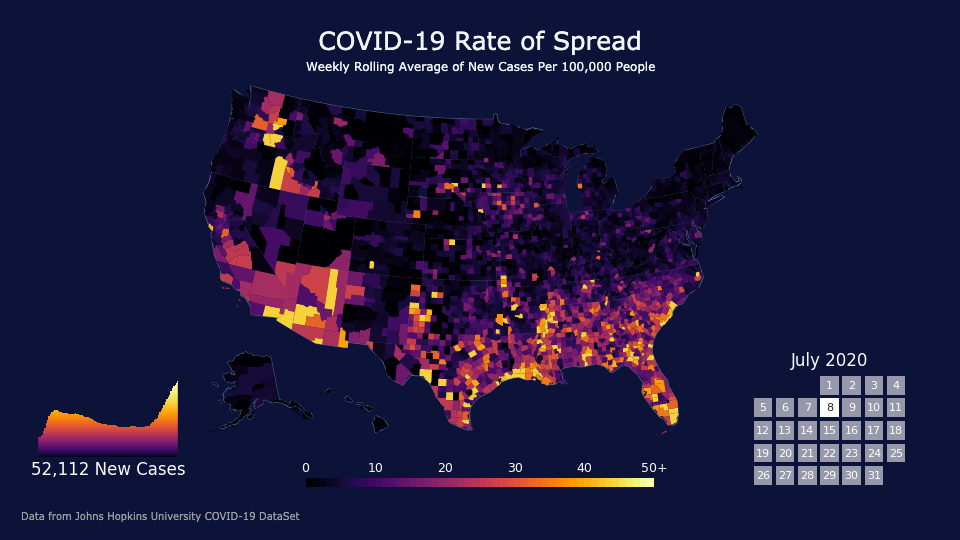

In [103]:
background = draw_single_choropleth(2020, 7,8)
display(background)
#Image(url=make_animation(5, 1, '90D', 'Inferno', 'covid19-county-spread-90day.gif', False))


In [ ]:
url = make_animation(30, '6H', 'Inferno', 'covid19-county-spread', True)
Video(url, embed=True)